In [46]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm import tqdm
from IPython import display
import time
from scipy.special import softmax
import pandas as pd

In [2]:
env = gym.make('Blackjack-v1')

# Simple strategy

In [3]:
N = 10000
r = np.zeros(N)

In [4]:
def dummy_stategy(player):
    if player == 19 or player == 20 or player == 21:
        return 0
    else:
        return 1

In [5]:
for i in range(N):
    state = env.reset()
    a = dummy_stategy(state[0])
    state, reward, finished, _ = env.step(a)
    while finished == False:
        a = dummy_stategy(state[0])
        state, reward, finished, _ = env.step(a)
        #print(state, finished, reward)
        if finished != False:
                break
    if finished == True:
        r[i] = reward

In [6]:
print("Average reward for winning over %d experiments: %.3f" %(N, r.mean()))

Average reward for winning over 10000 experiments: -0.204


# Q-learning strategy

In [7]:
def Q_update(state, state_next, a, reward_next, alpha=0.05, gamma=0.2):
    Q[state][a] += alpha * (reward_next + gamma * np.max(Q[state_next]) - Q[state][a])

In [8]:
def Q_init(state, finished=False):
    if state not in Q.keys():
        p = np.random.rand()
        Q[state] = np.array([p, 1 - p])

In [9]:
def calc_reward(N=10000):
    r = np.zeros(N)
    for i in tqdm(range(N)):
        finished = False
        state = env.reset()
        Q_init(state)
        while finished == False:
            a = np.argmax(Q[state])
            state_next, reward_next, finished_next, _ = env.step(a)
            #print(i, state_next, finished_next, reward_next)
            Q_init(state_next)
            state, finished = state_next, finished_next
            if finished != False:
                break
        r[i] = reward_next
    return r.mean()

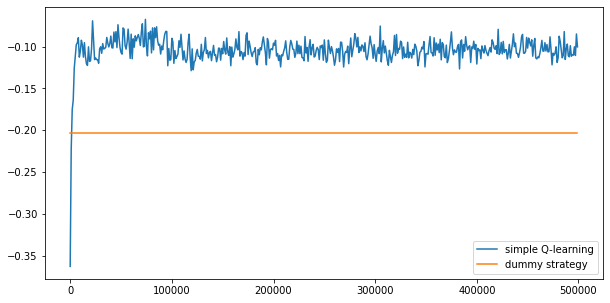

In [10]:
Q = {}
hit = 1
stand = 0
actions = [stand, hit]
epochs = 500000
reward_history = []
epoch = []
for i in range(epochs):
    finished = False
    state = env.reset()
    Q_init(state)
    while finished == False:
        a = np.argmax(Q[state])
        state_next, reward_next, finished_next, _ = env.step(a)
        Q_init(state_next)
        Q_update(state, state_next, a, reward_next)
        state, finished = state_next, finished_next
        if finished != False:
            break
            
    if i % 1000 == 0:
        reward_history.append(calc_reward())
        epoch.append(i)
        clear_output(wait=True)
        plt.figure(figsize=(10, 5))
        plt.plot(epoch, reward_history, label='simple Q-learning')
        plt.plot([0, epoch[-1]], [r.mean(), r.mean()], label='dummy strategy')
        plt.legend()
        plt.show()
    

# Double

In [11]:
def Q_init_double(state):
    if state not in Q.keys():
        x1 = np.random.rand()
        x2 = np.random.rand()
        x3 = np.random.rand()
        Q[state] = softmax(np.array([x1, x2, x3]))

In [12]:
def calc_reward_double(N=10000):
    r = np.zeros(N)
    for i in tqdm(range(N)):
        finished = False
        state = env.reset()
        Q_init_double(state)
        while finished == False:
            a = np.argmax(Q[state])
            if a == double:
                state_next, reward_next, finished_next, _ = env.step(1)
                state_next, reward_next, finished_next, _ = env.step(0)
                reward_next *= 2
                Q_init_double(state_next)
                state, finished = state_next, finished_next        
            else:
                state_next, reward_next, finished_next, _ = env.step(a)
                Q_init_double(state_next)
                state, finished = state_next, finished_next
            if finished != False:
                break
        r[i] = reward_next
    return r.mean()

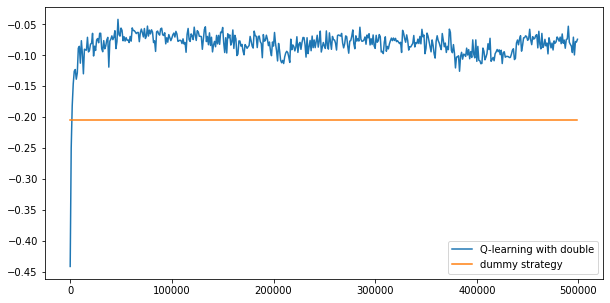

In [13]:
Q = {}
double = 2
hit = 1
stand = 0
epochs = 500000
reward_history_double = []
epoch = []
for i in range(epochs):
    finished = False
    state = env.reset()
    Q_init_double(state)
    while finished == False:
        a = np.argmax(Q[state])
        if a == double:
            state_next, reward_next, finished_next, _ = env.step(1)
            state_next, reward_next, finished_next, _ = env.step(0)
            reward_next *= 2
            Q_init_double(state_next)
            Q_update(state, state_next, a, reward_next)
            state, finished = state_next, finished_next
            
        
        else:
            state_next, reward_next, finished_next, _ = env.step(a)
            Q_init_double(state_next)
            Q_update(state, state_next, a, reward_next)
            state, finished = state_next, finished_next
        if finished != False:
            break
        
    
    
    if i % 1000 == 0:
        reward_history_double.append(calc_reward_double())
        epoch.append(i)
        clear_output(wait=True)
        plt.figure(figsize=(10, 5))
        plt.plot(epoch, reward_history_double, label='Q-learning with double')
        plt.plot([0, epoch[-1]], [r.mean(), r.mean()], label='dummy strategy')
        plt.legend()
        plt.show()

# Calculate cards

In [21]:
import gym
from gym import spaces
from gym.utils import seeding


def cmp(a, b):
    return float(a > b) - float(a < b)


# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10,
        1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10,
        1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10,
        1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]


def shuffle_deck(deck, np_random):
    return np_random.permutation(np.array(deck))


def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]


class BlackjackEnv(gym.Env):
    """Simple blackjack environment
    Blackjack is a card game where the goal is to obtain cards that sum to as
    near as possible to 21 without going over.  They're playing against a fixed
    dealer.
    Face cards (Jack, Queen, King) have point value 10.
    Aces can either count as 11 or 1, and it's called 'usable' at 11.
    This game is placed with an infinite deck (or with replacement).
    The game starts with dealer having one face up and one face down card, while
    player having two face up cards. (Virtually for all Blackjack games today).
    The player can request additional cards (hit=1) until they decide to stop
    (stick=0) or exceed 21 (bust).
    After the player sticks, the dealer reveals their facedown card, and draws
    until their sum is 17 or greater.  If the dealer goes bust the player wins.
    If neither player nor dealer busts, the outcome (win, lose, draw) is
    decided by whose sum is closer to 21.  The reward for winning is +1,
    drawing is 0, and losing is -1.
    The observation of a 3-tuple of: the players current sum,
    the dealer's one showing card (1-10 where 1 is ace),
    and whether or not the player holds a usable ace (0 or 1).
    This environment corresponds to the version of the blackjack problem
    described in Example 5.1 in Reinforcement Learning: An Introduction
    by Sutton and Barto.
    http://incompleteideas.net/book/the-book-2nd.html
    """

    def __init__(self, natural=False, sab=False):
        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Tuple(
            (spaces.Discrete(32), spaces.Discrete(11), spaces.Discrete(2))
        )
        self.seed()
        

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural

        # Flag for full agreement with the (Sutton and Barto, 2018) definition. Overrides self.natural
        self.sab = sab
        self.shuffled = shuffle_deck(deck, self.np_random)
        self.score = 0

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)
        
        if len(self.shuffled) < 15:
            self.shuffled = shuffle_deck(deck, self.np_random)
            self.score = 0
            
        if action:  # hit: add a card to players hand and return
            self.player.append(self.draw_card())
            if is_bust(self.player):
                done = True
                reward = -1.0
            else:
                done = False
                reward = 0.0
        else:  # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(self.draw_card())
            reward = cmp(score(self.player), score(self.dealer))
            if self.sab and is_natural(self.player) and not is_natural(self.dealer):
                # Player automatically wins. Rules consistent with S&B
                reward = 1.0
            elif (
                not self.sab
                and self.natural
                and is_natural(self.player)
                and reward == 1.0
            ):
                # Natural gives extra points, but doesn't autowin. Legacy implementation
                reward = 1.5
        return self._get_obs(), reward, done, {}
    
    def draw_card(self):
        card = self.shuffled[0]
        self.shuffled = self.shuffled[1:]
        return int(card)
    
    def draw_hand(self):
        card1 = self.draw_card()
        card2 = self.draw_card()
        return [card1, card2]

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player))

    def reset(self):
        self.score = 0
        if len(self.shuffled) < 15:
            self.shuffled = shuffle_deck(deck, self.np_random)
            self.score = 0
        self.dealer = self.draw_hand()
        self.player = self.draw_hand()
        return self._get_obs()

In [22]:
def calc_reward_double_calc(N=10000):
    r = np.zeros(N)
    for i in tqdm(range(N)):
        finished = False
        state_ = env.reset()
        state = (state_[0], state_[1], state_[2], env.score)
        Q_init_double(state)
        while finished == False:
            a = np.argmax(Q[state])
            if a == double:
                state_next_, reward_next, finished_next, _ = env.step(1)
                state_next_, reward_next, finished_next, _ = env.step(0)
                reward_next *= 2
                state_next = (state_next_[0], state_next_[1], state_next_[2], env.score)
                Q_init_double(state_next)
                state, finished = state_next, finished_next        
            else:
                state_next_, reward_next, finished_next, _ = env.step(a)
                state_next = (state_next_[0], state_next_[1], state_next_[2], env.score)
                Q_init_double(state_next)
                state, finished = state_next, finished_next
            if finished != False:
                break
        r[i] = reward_next
    return r.mean()

In [23]:
def calc_cards_halves(player, dealer):
    for card in player + dealer:
        if card == 2:
            env.score += 0.5
        elif card == 3 or card == 4:
            env.score += 1
        elif card == 5:
            env.score += 1.5
        elif card == 6:
            env.score += 1
        elif card == 7:
            env.score += 0.5
        elif card == 9:
            env.score -= 0.5
        elif card == 10 or card == 1:
            env.score -= 1

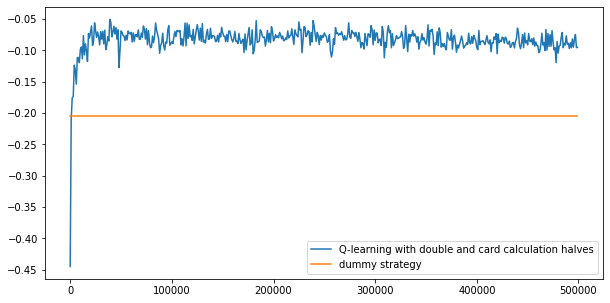

In [24]:
env = BlackjackEnv()
Q = {}
double = 2
hit = 1
stand = 0
epochs = 500000
reward_history_double_calc_halves = []
epoch = []
for i in range(epochs):
    finished = False
    state_ = env.reset()
    state = (state_[0], state_[1], state_[2], env.score)
    Q_init_double(state)
    while finished == False:
        a = np.argmax(Q[state])
        if a == double:
            state_next_, reward_next, finished_next, _ = env.step(1)
            state_next_, reward_next, finished_next, _ = env.step(0)
            reward_next *= 2
            
            state_next = (state_next_[0], state_next_[1], state_next_[2], env.score)
            Q_init_double(state_next)
            Q_update(state, state_next, a, reward_next)
            state, finished = state_next, finished_next
            
        
        else:
            state_next_, reward_next, finished_next, _ = env.step(a)
            state_next = (state_next_[0], state_next_[1], state_next_[2], env.score)
            Q_init_double(state_next)
            Q_update(state, state_next, a, reward_next)
            state, finished = state_next, finished_next
        if finished != False:
            break
    
    calc_cards_halves(env.player, env.dealer)
    if i % 1000 == 0:
        reward_history_double_calc_halves.append(calc_reward_double_calc())
        epoch.append(i)
        clear_output(wait=True)
        plt.figure(figsize=(10, 5))
        plt.plot(epoch, reward_history_double_calc_halves, label='Q-learning with double and card calculation halves')
        plt.plot([0, epoch[-1]], [r.mean(), r.mean()], label='dummy strategy')
        plt.legend()
        plt.show()

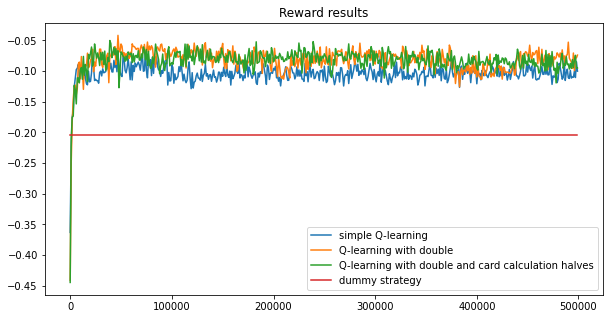

In [45]:
plt.figure(figsize=(10, 5))
plt.title('Reward results')
plt.plot(epoch, reward_history, label='simple Q-learning')
plt.plot(epoch, reward_history_double, label='Q-learning with double')
plt.plot(epoch, reward_history_double_calc_halves, label='Q-learning with double and card calculation halves')
plt.plot([0, epoch[-1]], [r.mean(), r.mean()], label='dummy strategy')
plt.legend()
plt.show()

In [57]:
print('Mean reward over last 400000 epochs for Q-learning:')
pd.DataFrame(np.array([['dummy strategy', 'simple Q-learning', 'Q-learning with double', 'Q-learning with double and card calculation halves'],
                       [r.mean(),
                        np.mean(reward_history[100:]), 
                        np.mean(reward_history_double[100:]), 
                        np.mean(reward_history_double_calc_halves[100:])]]).T, columns=['Methods', 'Rewards'])

Mean reward over last 400000 epochs for Q-learning:


,Methods,Rewards
0,dummy strategy,-0.2039
1,simple Q-learning,-0.104471
2,Q-learning with double,-0.08190125
3,Q-learning with double and card calculation ha...,-0.08131699999999999
